In [1]:
import warnings
import os

import pandas as pd
import numpy as np

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, callbacks



In [ ]:
list(df.iloc[:,:-1].columns)

#### split_subsample_sequence

In [2]:
import numpy as np

def subsample_sequence(df, length):
    """
    Given the initial dataframe `df`, return a shorter dataframe sequence of length `length`.
    This shorter sequence should be selected at random.
    """
    
    last_possible = df.shape[0] - length
    
    random_start = np.random.randint(0, last_possible)
    df_sample = df[random_start: random_start+length]
    
    return df_sample

def compute_means(X, df_mean):
    '''utils'''
    # Compute means of X
    means = X.mean()
    
    # Case if ALL values of at least one feature of X are NaN, then reaplace with the whole df_mean
    if means.isna().sum() != 0:
        means.fillna(df_mean, inplace=True)
        
    return means

def split_subsample_sequence(df, length, df_mean=None):
    '''Return one single random sample (X_sample, y_sample) containing one sequence each of length `length`'''
    # Trick to save time during potential recursive calls
    if df_mean is None:
        df_mean = df.mean()

    df_subsample = subsample_sequence(df, length)
    
    y_sample = df_subsample.iloc[length-1]['volume_gross']
    # Case y_sample is NaN: redraw !
    if y_sample != y_sample: # A value is not equal to itself only for NaN
            X_sample, y_sample = split_subsample_sequence(df, length, df_mean) # Recursive call !!!
            return np.array(X_sample), np.array(y_sample)

    X_sample = df_subsample[0:length-1]
    # Case X_sample has some NaNs
    if X_sample.isna().sum().sum() !=0:
        X_sample = X_sample.fillna(compute_means(X_sample, df_mean))
        X_sample = X_sample.values
        
    return np.array(X_sample), np.array(y_sample)

def get_X_y(df, n_sequences, length):
    '''Return a list of samples (X, y)'''
    # $CHALLENGIFY_BEGIN
    X, y = [], []

    for i in range(n_sequences):
        (xi, yi) = split_subsample_sequence(df, length)
        X.append(xi)
        y.append(yi)
        
    X = np.array(X)
    y = np.array(y)
    # $CHALLENGIFY_END
    return X, y


In [486]:
df_blockchain = pd.read_csv(os.path.join('final_df_2016.csv'), index_col=0 ,parse_dates=True)

data_path = '../raw_data/additional'
target = pd.read_csv(os.path.join(data_path, 'coinbase_2014-2021.csv'), index_col=0 ,parse_dates=True)

data_path = '../'
df_financial = pd.read_csv(os.path.join(data_path, 'financials_dataframe.csv'), index_col=0 ,parse_dates=True)

sentiment_df = pd.read_csv(os.path.join('reddit_twitter_fin.csv'), index_col=0 ,parse_dates=True
           ).loc['2016-06-30':][['tweets_sent','reddit_crypto_sent','reddit_econ_sent']]


df_tot = pd.concat([df_blockchain,df_financial,sentiment_df],axis=1)


In [708]:
df_tot

,n-transactions-per-block,difficulty,utxo-count,mvrv,nvt,avg-block-size,n-transactions-excluding-popular,n-unique-addresses,median-confirmation-time,n-payments,...,S&P U.S. Treasury Bond 7-10 Year Index (TTM JPY),S&P U.S. TIPS 7-10 Year Index (USD),S&P U.S. Treasury Bond 3-5 Year Index,S&P U.S. TIPS 3-5 Year Index (USD),S&P U.S. TIPS 1-3 Year Index (USD),S&P U.S. TIPS 5-7 Year Index (USD),S&P U.S. Treasury Bill 6-9 Month Index,tweets_sent,reddit_crypto_sent,reddit_econ_sent
2016-01-01,1041.690770,1.038803e+11,3.338612e+07,1.438947,13.175163,0.571189,151110.666667,263121.000000,7.333333,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-02,1027.848276,1.038803e+11,3.343719e+07,1.435261,14.288515,0.579744,146859.333333,290170.000000,7.233333,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-03,1072.431759,1.038803e+11,3.348825e+07,1.431575,15.401867,0.600422,142608.000000,317219.000000,7.133333,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-04,1117.015243,1.038803e+11,3.353932e+07,1.427888,16.515219,0.621101,152435.333333,344268.000000,7.905556,NaN,...,179.55,215.95,431.96,176.23,134.11,198.82,229.30,NaN,NaN,NaN
2016-01-05,1161.598726,1.038803e+11,3.353985e+07,1.427604,13.651511,0.641779,162262.666667,350924.000000,8.677778,NaN,...,178.44,215.97,431.98,176.26,134.11,198.87,229.33,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-18,2054.611695,2.267415e+13,7.682603e+07,2.437422,2.814664,1.270386,275592.333333,725020.000000,7.297222,695747.0,...,204.43,299.48,491.07,222.17,159.89,266.18,245.77,-0.191667,0.129760,0.164820
2021-11-19,2078.240876,2.267415e+13,7.692242e+07,2.423386,3.531133,1.275837,262180.666667,678741.666667,7.027778,689992.0,...,204.83,298.60,490.89,221.12,159.27,264.99,245.77,0.155357,0.058168,0.069516
2021-11-20,2078.240876,2.267415e+13,7.701882e+07,2.409351,4.247603,1.275837,248769.000000,632463.333333,6.758333,623208.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.466667,0.083604,0.014180
2021-11-21,2078.240876,2.267415e+13,7.711521e+07,2.409351,4.247603,1.275837,248769.000000,586185.000000,6.758333,570982.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.022500,0.173188,0.206028


In [534]:
df__ = df_tot.drop(columns=['n-payments','n-payments-per-block']
                  ).interpolate(
    method='linear',axis=0).dropna()
df__.index.min()

Timestamp('2016-06-30 00:00:00', freq='D')

/Users/michelangelodalessandro/.pyenv/versions/btc_sent_fc/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/michelangelodalessandro/.pyenv/versions/btc_sent_fc/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


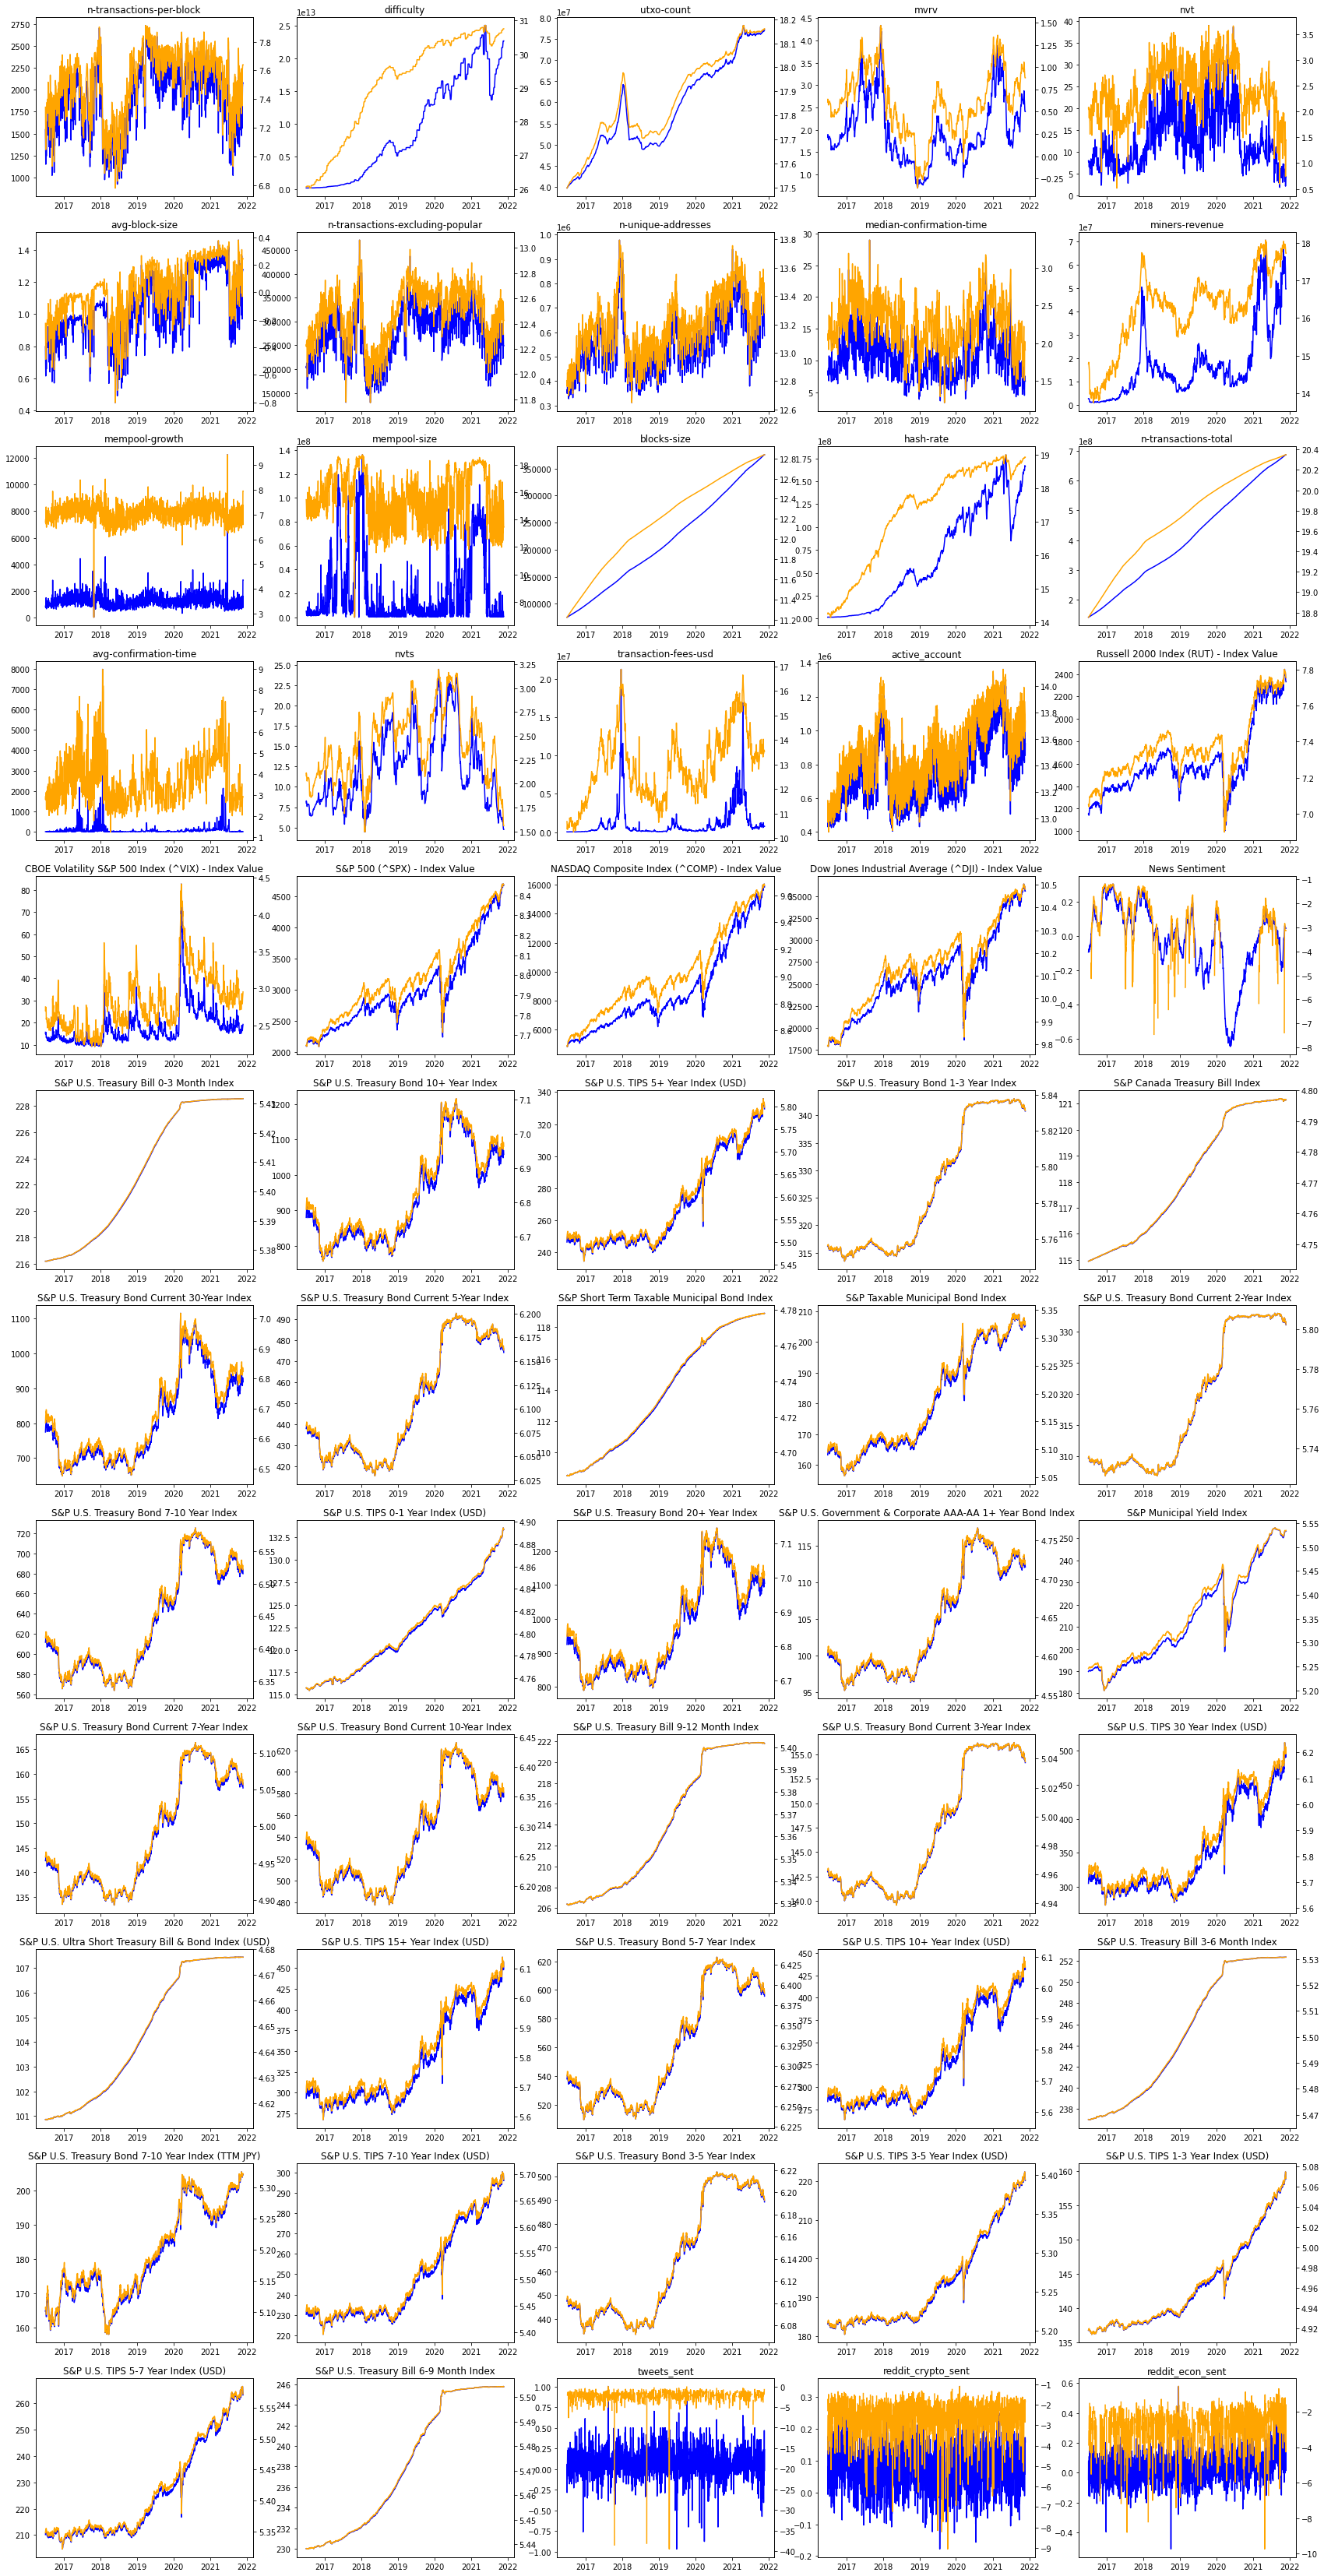

In [539]:
fig, axs = plt.subplots(12, 5, figsize = (29, 60))
axs = axs.flatten()
for idx, col in enumerate(df__.columns):
    ax2 = axs[idx].twinx()
    axs[idx].plot(df__[col], color= 'blue')
    ax2.plot(np.log(df__[col]), color = 'orange')
    axs[idx].set_title(col)

In [10]:
target = df[['volume_gross']]


NameError: name 'target' is not defined

In [767]:
df = pd.concat([df__,target],axis=1)


In [770]:
df.to_csv('features_2016.csv', index=True)

In [3]:
df = pd.read_csv(os.path.join('features_2016.csv'), index_col=0 ,parse_dates=True)


In [11]:
target = df[['volume_gross']]

In [4]:
df.head(2)

,n-transactions-per-block,difficulty,utxo-count,mvrv,nvt,avg-block-size,n-transactions-excluding-popular,n-unique-addresses,median-confirmation-time,miners-revenue,...,S&P U.S. TIPS 7-10 Year Index (USD),S&P U.S. Treasury Bond 3-5 Year Index,S&P U.S. TIPS 3-5 Year Index (USD),S&P U.S. TIPS 1-3 Year Index (USD),S&P U.S. TIPS 5-7 Year Index (USD),S&P U.S. Treasury Bill 6-9 Month Index,tweets_sent,reddit_crypto_sent,reddit_econ_sent,volume_gross
2016-06-30,1546.400000,2.094532e+11,39737471.0,1.835217,7.901799,0.797510,205005.0,363625.0,8.344444,2.633621e+06,...,230.23,447.49,183.10,136.77,210.16,230.05,0.000000,0.175696,-0.046658,1.015565e+07
2016-07-01,1414.325108,2.094532e+11,39764401.0,1.896975,7.678641,0.736557,202414.0,356294.0,8.166667,2.669238e+06,...,231.32,447.52,183.45,136.87,210.81,230.06,-0.283333,0.102044,0.078542,9.049903e+06


### DF__, target

In [773]:
#df = pd.concat([df__,target],axis=1)

#df_all_d = df[:-1]
#y_1_d = y.iloc[-1,:]

In [5]:
S_A = df[['tweets_sent','reddit_crypto_sent','reddit_econ_sent','News Sentiment','mempool-size']]

df_no_SA = df.drop(columns= ['tweets_sent','reddit_crypto_sent','reddit_econ_sent',
                             'News Sentiment','mempool-size'])


In [ ]:
def set_pipeline(self):
    log = FunctionTransformer(lambda x: np.log(x))
    
    log_col = Pipeline([('log',log),
    ('imputer', KNNImputer()),
    ('scaler', StandardScaler())
    ])
    
    
    target_col = Pipeline([('log',log),
    ('imputer', KNNImputer())])
    
    no_log_col = Pipeline([
    ('imputer', KNNImputer()),
    ('scaler', StandardScaler())])
    
    preproc_pipe = make_column_transformer(
    (log_col, ....),
    (no_log_col, ....),(target_col, ...),
    remainder='passthrough')

        
    self.pipeline = Pipeline([('preproc', preproc_pipe),
                                  ('KNN', estimator)])


In [6]:
df_no_SA = df_no_SA.apply(lambda x: np.log(x))

In [7]:
len_ = int(0.8*df.shape[0])
df_no_SA = pd.concat([S_A,df_no_SA],axis=1)
df_train = df_no_SA.iloc[:len_,:-1]
df_test = df_no_SA.iloc[len_:,:-1]

In [8]:
from sklearn.preprocessing import StandardScaler
columns = df.columns

scaler = StandardScaler()
df_train = pd.DataFrame(scaler.fit_transform(df_train), 
                        columns=df_train.columns,
                       index= df_train.index)
df_test = pd.DataFrame(scaler.transform(df_test), 
                       columns=df_test.columns,
                      index= df_test.index)
df_train.head(2)


,tweets_sent,reddit_crypto_sent,reddit_econ_sent,News Sentiment,mempool-size,n-transactions-per-block,difficulty,utxo-count,mvrv,nvt,...,S&P U.S. Treasury Bond 5-7 Year Index,S&P U.S. TIPS 10+ Year Index (USD),S&P U.S. Treasury Bill 3-6 Month Index,S&P U.S. Treasury Bond 7-10 Year Index (TTM JPY),S&P U.S. TIPS 7-10 Year Index (USD),S&P U.S. Treasury Bond 3-5 Year Index,S&P U.S. TIPS 3-5 Year Index (USD),S&P U.S. TIPS 1-3 Year Index (USD),S&P U.S. TIPS 5-7 Year Index (USD),S&P U.S. Treasury Bill 6-9 Month Index
2016-06-30,-0.398522,1.437090,-0.760201,-0.319173,-0.464532,-0.835741,-1.848287,-2.035351,0.215444,-0.835073,...,-0.236053,-0.592342,-1.224063,-1.034625,-0.618272,-0.370806,-0.816268,-1.065037,-0.765711,-1.154307
2016-07-01,-2.109771,0.374238,0.661493,-0.305052,-0.494380,-1.246231,-1.848287,-2.030854,0.309228,-0.891862,...,-0.226634,-0.484046,-1.224063,-0.995258,-0.540734,-0.369352,-0.761936,-1.036290,-0.701986,-1.152409


In [12]:
t_log = target.copy().apply(lambda x: np.log(x))

In [13]:
t_log_train = t_log[:len_]
t_log_test = t_log[len_:]

In [14]:
df_train = pd.concat([df_train,t_log_train],axis=1)
df_test = pd.concat([df_test,t_log_test],axis=1)

In [15]:
df_train.head()

,tweets_sent,reddit_crypto_sent,reddit_econ_sent,News Sentiment,mempool-size,n-transactions-per-block,difficulty,utxo-count,mvrv,nvt,...,S&P U.S. TIPS 10+ Year Index (USD),S&P U.S. Treasury Bill 3-6 Month Index,S&P U.S. Treasury Bond 7-10 Year Index (TTM JPY),S&P U.S. TIPS 7-10 Year Index (USD),S&P U.S. Treasury Bond 3-5 Year Index,S&P U.S. TIPS 3-5 Year Index (USD),S&P U.S. TIPS 1-3 Year Index (USD),S&P U.S. TIPS 5-7 Year Index (USD),S&P U.S. Treasury Bill 6-9 Month Index,volume_gross
2016-06-30,-0.398522,1.437090,-0.760201,-0.319173,-0.464532,-0.835741,-1.848287,-2.035351,0.215444,-0.835073,...,-0.592342,-1.224063,-1.034625,-0.618272,-0.370806,-0.816268,-1.065037,-0.765711,-1.154307,16.133541
2016-07-01,-2.109771,0.374238,0.661493,-0.305052,-0.494380,-1.246231,-1.848287,-2.030854,0.309228,-0.891862,...,-0.484046,-1.224063,-0.995258,-0.540734,-0.369352,-0.761936,-1.036290,-0.701986,-1.152409,16.018265
2016-07-02,-0.041630,-1.182038,-0.620010,-0.287464,-0.531783,-1.696992,-1.848173,-2.026121,0.299552,-0.864235,...,-0.456955,-1.224063,-1.010581,-0.519281,-0.354942,-0.754182,-1.031980,-0.689264,-1.152409,15.728642
2016-07-03,-0.398522,-0.881685,0.007401,-0.269876,-0.569186,-2.196796,-1.848060,-2.021392,0.289843,-0.836987,...,-0.429947,-1.224063,-1.025919,-0.497855,-0.340541,-0.746431,-1.027670,-0.676551,-1.152409,15.945403
2016-07-04,-0.398522,-0.506893,0.305594,-0.252288,-0.594578,-1.712429,-1.847946,-2.016666,0.280100,-0.810109,...,-0.403023,-1.224063,-1.041273,-0.476457,-0.326149,-0.738682,-1.023361,-0.663845,-1.152409,15.544455


In [16]:
X_train, y_train = get_X_y(df_train, 2000, 90)
print(X_train.shape)
print(y_train.shape)

(2000, 89, 61)
(2000,)


In [ ]:
y_train.

In [17]:
X_test, y_test = get_X_y(df_test, 400, 90)
print(X_test.shape)
print(y_test.shape)

(400, 89, 61)
(400,)


In [18]:
# Or (better) we predict the last pollution value!
y_pred_baseline = X_test[:,-1,60]
bench_res = np.mean(np.abs(y_pred_baseline - y_test)/y_test)*100
print(f'Benchmark MAPE on the test set : {bench_res:.0f} %')

Benchmark MAPE on the test set : 2 %


## Sequences
This section aims to create a training set suitable for a RNN:
```python
X.shape = (n_sequences, length, n_features) # e.g. (100, 20, 7)
y.shape = (n_sequences, ) # e.g. (100,)
```

## SIMPLE RNN


In [19]:
from keras.metrics import MeanAbsoluteError,MeanAbsolutePercentageError
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from keras.layers import Dropout

from tensorflow.keras.layers import SimpleRNN, LSTM, GRU

from tensorflow.keras import optimizers


In [20]:
X_train.shape

(2000, 89, 61)

In [60]:
normalizer = Normalization()
normalizer.adapt(X_train)

In [61]:
def initial_model():
    
    model = Sequential()
    #model.add(normalizer)
    
    opt = optimizers.Adam(learning_rate=0.1)
    
    model.add(LSTM(units = 50,activation='tanh', return_sequences = True)) # dropout = 0.2
    #model.add(Dropout(0.2))
    model.add(LSTM(units = 100,activation='tanh', return_sequences = False))
    #model.add(Dropout(0.2))


    
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    
    model.compile(loss='mae', 
              optimizer=opt,
                 metrics=[MeanAbsoluteError(),
                         MeanAbsolutePercentageError()])
    
    return model


In [818]:
## mae, 
## colleration loss, 7 day  window.


In [39]:
es = callbacks.EarlyStopping(patience=20)

model = initial_model()

history = model.fit(X_train,y_train,
       validation_split = 0.2,
        epochs=50,
         callbacks=[es],
          verbose=1)

Epoch 1/50
50/50 [==============================] - 11s 122ms/step - loss: 1.6315 - mean_absolute_error: 1.6315 - mean_absolute_percentage_error: 8.9826 - val_loss: 0.9566 - val_mean_absolute_error: 0.9566 - val_mean_absolute_percentage_error: 5.1760
Epoch 2/50
50/50 [==============================] - 6s 124ms/step - loss: 1.1329 - mean_absolute_error: 1.1329 - mean_absolute_percentage_error: 6.2320 - val_loss: 1.6827 - val_mean_absolute_error: 1.6827 - val_mean_absolute_percentage_error: 8.9024
Epoch 3/50
50/50 [==============================] - 6s 119ms/step - loss: 1.1072 - mean_absolute_error: 1.1072 - mean_absolute_percentage_error: 6.0309 - val_loss: 0.7956 - val_mean_absolute_error: 0.7956 - val_mean_absolute_percentage_error: 4.3720
Epoch 4/50
50/50 [==============================] - 6s 116ms/step - loss: 1.0167 - mean_absolute_error: 1.0167 - mean_absolute_percentage_error: 5.5484 - val_loss: 0.8415 - val_mean_absolute_error: 0.8415 - val_mean_absolute_percentage_error: 4.6813

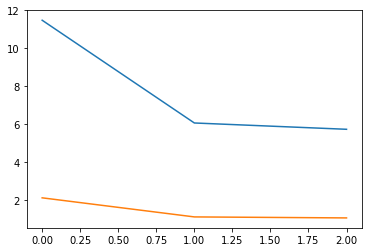

In [24]:
import matplotlib.pyplot as plt
plt.plot(history.history['mean_absolute_percentage_error'])
plt.plot(history.history['mean_absolute_error'])


In [40]:
res = model.evaluate(X_test, y_test, verbose=0)

print(f'MAPE on the test set : {res[2]:.0f} %')


MAPE on the test set : 14 %


In [51]:
X_train[0].shape

(89, 61)

In [42]:
import joblib

joblib.dump(model, 'model_RNN_1.joblib')


INFO:tensorflow:Assets written to: ram://f5ee4c73-e150-4aee-ad97-309d1fe9dfb4/assets


INFO:tensorflow:Assets written to: ram://f5ee4c73-e150-4aee-ad97-309d1fe9dfb4/assets


['model_RNN_1.joblib']

In [63]:
X_pred = np.zeros((1,89,61))
